In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))  # setup đường dẫn

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Models

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay
)

In [2]:
input_path = "../data/processed/Global_Landslide_Processed.csv"
df = pd.read_csv(input_path)
df.head()

,source_name,event_date,event_title,event_description,location_description,location_accuracy,landslide_category,landslide_trigger,landslide_size,landslide_setting,...,injury_count,country_name,admin_division_name,admin_division_population,gazeteer_closest_point,gazeteer_distance,longitude,latitude,fatality_imputed,injury_imputed
0,AGU,2008-08-01 00:00:00,sigou village loufan county shanxi province,occurred early in morning 11 villagers buried ...,sigou village loufan county shanxi province,unknown,landslide,Rain,large,mine,...,0,china,shaanxi,127225.0,Jingyang,41.02145,107.4500,32.5625,False,False
1,Oregonian,2009-01-02 02:00:00,lake oswego oregon,hours of heavy rain are to blame for an overni...,lake oswego oregon,5km,mudslide,Downpour,small,unknown,...,0,united states,oregon,36619.0,Lake Oswego,0.60342,-122.6630,45.4200,False,False
2,CBS News,2007-01-19 00:00:00,san ramon district 195 miles northeast of the ...,cbs ap at least 10 people died and as many as ...,san ramon district 195 miles northeast of the ...,10km,landslide,Downpour,large,unknown,...,0,peru,junín,14708.0,San Ramón,0.85548,-75.3587,-11.1295,False,False
3,Reuters,2009-07-31 00:00:00,dailekh district,one person was killed in dailekh district poli...,dailekh district,unknown,landslide,Monsoon,medium,unknown,...,0,nepal,mid western,20908.0,Dailekh,0.75395,81.7080,28.8378,False,False
4,The Freeman,2010-10-16 12:00:00,sitio bakilid in barangay lahug,another landslide in sitio bakilid in barangay...,sitio bakilid in barangay lahug,5km,landslide,Tropical cyclone,medium,unknown,...,0,philippines,central visayas,798634.0,Cebu City,2.02204,123.8978,10.3336,False,False


**Câu hỏi 3: Dựa trên các đặc điểm về nguyên nhân kích hoạt, thời gian, và bối cảnh địa lý của các vụ sạt lở, có thể xây dựng mô hình học máy để phân loại và cảnh báo sớm xem một vụ sạt lở có khả năng gây thương vong cho con người (tử vong hoặc bị thương) hay không?**

**Động lực và lợi ích:**
- Câu hỏi này đáng để điều tra vì trong quản lý thiên tai, ưu tiên hàng đầu là bảo vệ tính mạng con người. Việc biết chính xác số người chết đôi khi không quan trọng bằng việc biết ngay lập tức liệu sự kiện đó có "nguy hiểm tính mạng" hay không để kích hoạt báo động khẩn cấp.
- Trả lời câu hỏi này sẽ mang lại lợi ích: Giúp lọc nhiễu. Có hàng ngàn vụ sạt lở nhỏ xảy ra mỗi năm không gây hại. Mô hình này giúp loại bỏ các cảnh báo về các vụ sạt lở vô hại, tập trung nguồn lực vào các vụ có ảnh hưởng nguy hiểm đến con người.
- Vấn đề thực tế:
    + Ví dụ: Hệ thống cảnh báo sớm: "Cảnh báo! Vụ sạt lở do mưa lớn tại khu vực dân cư X có 90% xác suất gây thương vong. Yêu cầu sơ tán ngay lập tức."

**Thiết lập bài toán học máy**:
- Loại bài toán: Phân loại nhị phân (Binary Classification).
- Chia tập dữ liệu: bộ dữ liệu sẽ được thành tập train và tập test dựa vào năm sự kiện sạt lở đó xảy ra
    + Tập train: Lấy các sự kiện có năm nhỏ hơn 2016.
    + Tập test: Lấy các sự kiện có năm lớn hơn 2016.
- Các mô hình được xây dựng:
    + Logistic Regression: được sử dụng để dự đoán xác suất xảy ra của một sự kiện thông qua ngưỡng  (ví dụ: Có thương vong hay Không). Mô hình cơ sở để bắt đầu mọi bài toán phân loại.
    + Random Forest Classifier: Sử dụng nhiều cây quyết định, từng cây sẽ có dự đoán riêng. Kết quả cuối cùng được chọn theo nguyên tắc đa số. Xử lý phi tuyến tính: Sạt lở đất là hiện tượng phức tạp không phải lúc nào cũng là đường thẳng.

**Triển khai:**
- Danh sách các đặc trưng (Biến đầu vào) đưa vào mô hình để dự đoán kết quả:
    + landslide_size (Quy mô)
    + landslide_trigger (Nguyên nhân)
    + landslide_setting (Bối cảnh)
    + admin_division_population (Dân số)
    + landslide_category (Loại hình)
    + month (Thời gian - Yếu tố mùa vụ)
    + country_name (Lấy top 10 quốc gia có nhiều vụ sạt lở nhất)
- Biến đầu ra: tạo đặc trưng human_casualty (thiệt hại về người) từ fatality_count và injury_count 

In [3]:
# Từ event_date tạo ra 2 đặc trưng year, month
df['event_date'] = pd.to_datetime(df['event_date'], format='mixed', dayfirst=False, errors='coerce')
df['year'] = df['event_date'].dt.year
df['month'] = df['event_date'].dt.month

# Tạo target: Human Casualty (0 hoặc 1)
df['human_casualty'] = ((df['fatality_count'] > 0) | (df['injury_count'] > 0)).astype(int)
df.human_casualty.value_counts()

human_casualty
0    8350
1    2683
Name: count, dtype: int64

MÃ HÓA (ENCODING)

In [4]:
# ---------------------------------------------------------
# MÃ HÓA (ENCODING)
# ---------------------------------------------------------
# A. Ordinal Encoding cho landslide_size (Quy ước thủ công)
size_mapping = {
    'small': 1, 
    'medium': 2,
    'large': 3,
    'very_large': 4, 'catastrophic': 4,
    'nan': 2, 'unknown': 2 # Xử lý các giá trị lạ/thiếu bằng mức trung bình
}
# Map vào dữ liệu, những cái không có trong từ điển sẽ thành NaN -> điền là 2
df['landslide_size_encoded'] = df['landslide_size'].map(size_mapping).fillna(2)

# B. Gom nhóm Country (Giữ Top 10 nước, còn lại là 'Other')
top_countries = df['country_name'].value_counts().nlargest(10).index
df['country_group'] = df['country_name'].apply(lambda x: x if x in top_countries else 'Other')


cols_to_use = ['landslide_size_encoded', 'admin_division_population', 'month',
               'landslide_trigger', 'landslide_setting', 'landslide_category', 'country_group', 'year']

# Tạo X (Features) bằng cách One-Hot Encoding (tự động biến đổi các cột chữ)
df_encoded = pd.get_dummies(df[cols_to_use], columns=['landslide_trigger', 'landslide_setting',
                                             'landslide_category', 'country_group'], drop_first=True)
y = df['human_casualty']

CHIA TẬP TRAIN / TEST

In [5]:
# ---------------------------------------------------------
# CHIA TẬP TRAIN / TEST
# ---------------------------------------------------------
# Tách tập Train (Năm < 2016)
X_train = df_encoded[df_encoded['year'] < 2016].copy()
y_train = y[df_encoded['year'] < 2016]

# Tách tập Test (Năm >= 2016)
X_test = df_encoded[df_encoded['year'] >= 2016].copy()
y_test = y[df_encoded['year'] >= 2016]

X_train = X_train.drop(columns=['year'])
X_test = X_test.drop(columns=['year'])

CHUẨN HÓA (SCALING) cho biến 'admin_division_population'

In [6]:
# ---------------------------------------------------------
# CHUẨN HÓA (SCALING)
# ---------------------------------------------------------
scaler = StandardScaler()
# Chỉ fit trên tập train để tránh lộ thông tin sang tập test
X_train[['admin_division_population']] = scaler.fit_transform(X_train[['admin_division_population']])
X_test[['admin_division_population']] = scaler.transform(X_test[['admin_division_population']])

In [7]:
# ---------------------------------------------------------
# 5. KIỂM TRA KẾT QUẢ
# ---------------------------------------------------------
print("Kích thước tập huấn luyện:", X_train.shape)
print(f"Số lượng mẫu tập Train (< 2016): {len(X_train)} ({len(X_train)/len(df):.1%})")
print(f"Số lượng mẫu tập Test (>= 2016): {len(X_test)} ({len(X_test)/len(df):.1%})")
print("-" * 30)
print(f"Tỷ lệ thương vong trong quá khứ (Train): {y_train.mean():.2%}")
print(f"Tỷ lệ thương vong trong tương lai (Test): {y_test.mean():.2%}")

Kích thước tập huấn luyện: (8595, 54)
Số lượng mẫu tập Train (< 2016): 8595 (77.9%)
Số lượng mẫu tập Test (>= 2016): 2438 (22.1%)
------------------------------
Tỷ lệ thương vong trong quá khứ (Train): 25.17%
Tỷ lệ thương vong trong tương lai (Test): 21.33%


1. HUẤN LUYỆN MÔ HÌNH 1: LOGISTIC REGRESSION

In [8]:
print("Đang huấn luyện Logistic Regression...")
# class_weight='balanced': Giúp mô hình chú ý hơn, quan tâm hơn vào lớp thiểu số (Có thương vong)
log_reg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
log_reg.fit(X_train, y_train)

# Dự đoán
y_pred_log = log_reg.predict(X_test)
y_prob_log = log_reg.predict_proba(X_test)[:, 1]

Đang huấn luyện Logistic Regression...


2. HUẤN LUYỆN MÔ HÌNH 2: RANDOM FOREST

In [9]:
print("Đang huấn luyện Random Forest...")
# n_estimators=100: Số cây trong rừng
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Dự đoán
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

Đang huấn luyện Random Forest...


ĐÁNH GIÁ VÀ SO SÁNH MÔ HÌNH

In [10]:
# ---------------------------------------------------------
# 3. ĐÁNH GIÁ VÀ SO SÁNH (PHẦN QUAN TRỌNG NHẤT)
# ---------------------------------------------------------
print("\n--- KẾT QUẢ LOGISTIC REGRESSION ---")
print(classification_report(y_test, y_pred_log))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_log):.2f}")

print("\n--- KẾT QUẢ RANDOM FOREST ---")
print(classification_report(y_test, y_pred_rf))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_rf):.2f}")


--- KẾT QUẢ LOGISTIC REGRESSION ---
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1918
           1       0.49      0.54      0.52       520

    accuracy                           0.78      2438
   macro avg       0.68      0.70      0.69      2438
weighted avg       0.79      0.78      0.79      2438

ROC-AUC: 0.81

--- KẾT QUẢ RANDOM FOREST ---
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      1918
           1       0.56      0.29      0.39       520

    accuracy                           0.80      2438
   macro avg       0.70      0.62      0.63      2438
weighted avg       0.77      0.80      0.78      2438

ROC-AUC: 0.78


Recall (độ nhạy)
- Logistic Regression (0.54): Trong 100 vụ sạt lở chết người thực tế, mô hình phát hiện được 54 vụ.
- Random Forest (0.29): Trong 100 vụ sạt lở chết người thực tế, mô hình chỉ phát hiện được 29 vụ. Nó bỏ sót tới 71 vụ.
-> Random Forest bỏ sót quá nhiều mối nguy hiểm.
ROC-AUC: Đo khả năng phân tách giữa lớp 0 và 1 của mô hình. ROC-AUC đánh giá mô hình ở mọi ngưỡng cắt
- Logistic Regression (0.81): Mức điểm Tốt (>0.8)
- Random Forest (0.78): Mức điểm Khá (<0.8).
Precision (Độ tin cậy)
- Logistic Regression (0.49): Khi nó báo động, chỉ có 49% là thật, 51% là báo động giả.
- Random Forest (0.56): Khi nó báo động, 56% là thật.

Vẽ ROC Curve

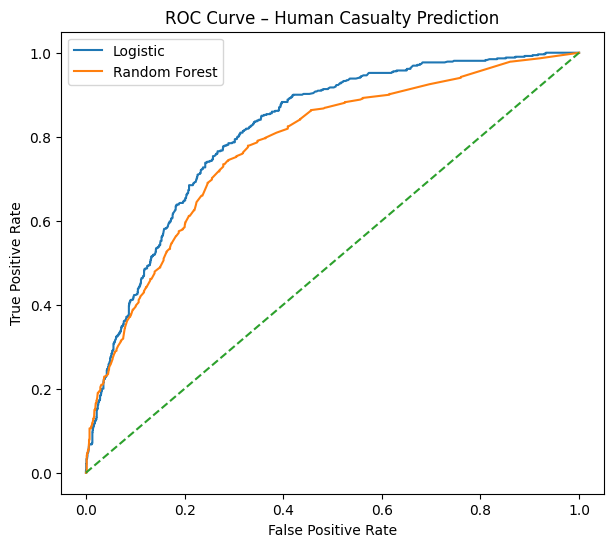

In [11]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(7,6))
plt.plot(fpr_log, tpr_log, label='Logistic')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Human Casualty Prediction")
plt.legend()
plt.show()


-> Là đường cong biểu diễn mối tương quan. Mô hình LOGISTIC REGRESSION tốt hơn 

Confusion Matrix

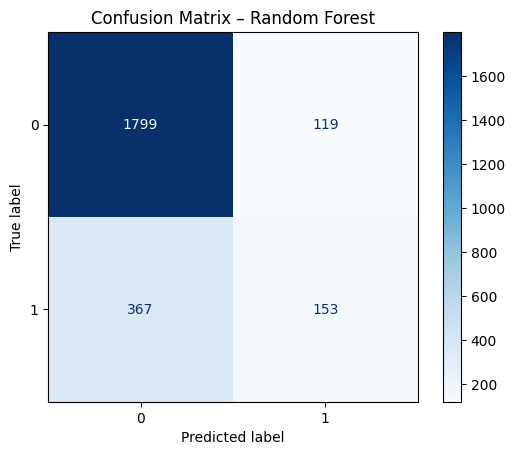

In [12]:
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf, cmap='Blues'
)
plt.title("Confusion Matrix – Random Forest")
plt.show()


Feature Importance (Diễn giải)

In [13]:
importances = rf_model.feature_importances_
features = X_train.columns

fi = pd.Series(importances, index=features).sort_values(ascending=False).head(10)
print(fi)

admin_division_population       0.366719
country_group_united states     0.142843
month                           0.137464
landslide_size_encoded          0.063085
landslide_setting_above road    0.044570
landslide_setting_unknown       0.017978
country_group_india             0.016170
country_group_china             0.014611
landslide_trigger_Other         0.014382
landslide_category_landslide    0.014342
dtype: float64
